# **Bitmap Caesar**

## Enhancing Security with the Caesar Cipher

Before embedding the message in the image using Base64 encoding, an additional layer of obfuscation can be applied to make the message more secure. One simple technique for this is the **Caesar Cipher**. Named after Julius Caesar, who reportedly used it in his private correspondence, the Caesar Cipher is a substitution cipher that shifts each character in the plaintext by a fixed number of positions in the alphabet.

By applying a Caesar Cipher to the message prior to Base64 encoding, you introduce an extra hurdle for anyone trying to extract and interpret the hidden message without the necessary key. This is particularly useful when the steganographic embedding is coupled with plaintext messages. However, in real-world scenarios, more advanced encryption techniques should be used for sensitive information as the Caesar Cipher is relatively easy to break.

### How the Caesar Cipher Works

The Caesar Cipher replaces each letter in the message with another letter a fixed number of positions down (or up) the alphabet. For example, with a shift of 3:

- `A` becomes `D`
- `B` becomes `E`
- `C` becomes `F`

The process wraps around at the end of the alphabet, so `X` becomes `A`, `Y` becomes `B`, and `Z` becomes `C`. Numbers and punctuation are typically left unchanged, but this can vary based on implementation.

To decrypt a Caesar Cipher message, the recipient simply shifts the letters in the opposite direction by the same number of positions.

## Encoding with Caesar Cipher and Base64

Here’s how the process works:

1. **Plaintext Message:** Start with the original message (e.g., `"im a cat"`).
2. **Apply Caesar Cipher:** Obfuscate the message using a chosen shift value (e.g., `3`). The message `"im a cat"` might become `"lp d fdw"`.
3. **Encode in Base64:** Convert the obfuscated message into Base64, producing a string of printable characters.
4. **Embed in Image:** Use LSB steganography to embed the Base64-encoded string into the image.

By combining Caesar Cipher obfuscation with LSB steganography, you can enhance the security of your hidden messages while exploring the principles of encryption and steganography. Here is how you can implement this in your code:

```{admonition} Note
:class: note
You may need to update the `path` variable to point to the image you want to use.
```

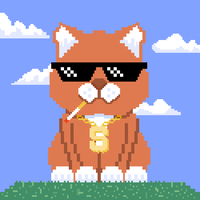

In [4]:
from PIL import Image
from IPython.display import display
img = Image.open("cat.bmp")
display(img)

In [2]:
import os

path = os.getcwd()

def ceaser_cipher_encode(input_string, shift):
    encoded_string = ""
    for character in input_string:
        if character.isalpha():
            base = ord('a') if character.islower() else ord('A')
            encoded_string += chr((ord(character) - base + shift) % 26 + base)
        else:
            encoded_string += character  # Non-alphabet characters remain unchanged
    return encoded_string

def base64_encode(input_string):
    BASE64_CHARS = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/"
    encoded_string = ""
    value = 0
    bits = -6
    base64_mask = 0x3F

    for character in input_string.encode():
        value = (value << 8) + character
        bits += 8

        while bits >= 0:
            encoded_string += BASE64_CHARS[(value >> bits) & base64_mask]
            bits -= 6
    
    if bits > -6:
        encoded_string += BASE64_CHARS[((value << 8) >> (bits + 8)) & base64_mask]
    
    while len(encoded_string) % 4:
        encoded_string += "="
    
    return encoded_string

# This will allow us to highlight the differences in the binary data
def highlight_changes(original, modified):
    highlighted_original = []
    highlighted_modified = []

    for o, m in zip(original, modified):
        if o != m:
            highlighted_original.append(f"[{o}]")
            highlighted_modified.append(f"[{m}]")
        else:
            highlighted_original.append(o)
            highlighted_modified.append(m)

    return ''.join(highlighted_original), ''.join(highlighted_modified)

def embed_message(data, message, offset, shift):
    # Apply Caesar cipher shift to the message
    shifted_message = ceaser_cipher_encode(message, shift)
    print(f"Caesar cipher shifted message: {shifted_message}")

    # Encode the shifted message using Base64
    base64_message = base64_encode(shifted_message)
    print(f"Base64-encoded message: {base64_message}")
    print(f"Base64 length (in characters): {len(base64_message)}")

    # Convert the Base64 message to binary
    binary_message = ''.join(format(ord(char), '08b') for char in base64_message)
    print(f"Binary message: {binary_message}")

    # Embed the length of the Base64 message (in bytes) in the first 32 bits
    length_bits = format(len(base64_message), '032b')
    print(f"Length bits: {length_bits}")

    data = bytearray(data)

    # Extract original binary at embedding positions
    original_binary = "".join(format(data[offset + i], '08b') for i in range(len(length_bits + binary_message)))
    modified_data = bytearray(data)

    # Embed the message into the least significant bits
    for i, bit in enumerate(length_bits + binary_message):
        modified_data[offset + i] = (modified_data[offset + i] & 0xFE) | int(bit)

    # Extract modified binary at embedding positions
    modified_binary = "".join(format(modified_data[offset + i], '08b') for i in range(len(length_bits + binary_message)))

    highlighted_original, highlighted_modified = highlight_changes(original_binary, modified_binary)
    
    # Truncate for readability
    def truncate_binary(binary_str, show_bits=64):
        if len(binary_str) > show_bits * 2:
            return binary_str[:show_bits] + "..." + binary_str[-show_bits:]
        return binary_str

    print("\nOriginal binary data at embedding positions (truncated):")
    print(truncate_binary(highlighted_original))

    print("\nModified binary data at embedding positions (truncated):")
    print(truncate_binary(highlighted_modified))

    return modified_data

input_file_path = os.path.join(path, "cat.bmp")
output_file_path = os.path.join(path, "hiddencat.bmp")
with open(input_file_path, "rb") as f:
    data = f.read()

print("Enter the message to embed: ")
message_to_embed = input()
print(f"{message_to_embed}")

print("Enter the Caesar cipher shift value: ")
shift_value = int(input())
print(f"{shift_value}")

# Specify the offset where the pixel data starts (e.g., 54 for standard BMP)
pixel_data_offset = int.from_bytes(data[10:14], byteorder='little')

encoded_data = embed_message(data, message_to_embed, pixel_data_offset, shift_value)
with open(output_file_path, "wb") as f:
    f.write(encoded_data)
print(f"Message embedded successfully in Base64! Encoded image saved as {output_file_path}.")

Enter the message to embed: 
Hi! I'm a cool cat!
Enter the Caesar cipher shift value: 
18
Caesar cipher shifted message: Za! A'e s uggd usl!
Base64-encoded message: WmEhIEEnZSBzIHVnZ2QgdXNsIQ==
Base64 length (in characters): 28
Binary message: 01010111011011010100010101101000010010010100010101000101011011100101101001010011010000100111101001001001010010000101011001101110010110100011001001010001011001110110010001011000010011100111001101001001010100010011110100111101
Length bits: 00000000000000000000000000011100

Original binary data at embedding positions (truncated):
0110011[1]10001110010000100110011[1]10001110010000100110011[1]10...0110011[1]1000111[0]0100001[0]011001111000111[0]0100001001100111

Modified binary data at embedding positions (truncated):
0110011[0]10001110010000100110011[0]10001110010000100110011[0]10...0110011[0]1000111[1]0100001[1]011001111000111[1]0100001001100111
Message embedded successfully in Base64! Encoded image saved as /run/media/breezy/b1de4ffb-fd5e-4613-986d

The comparison between the original and modified binary data highlights the subtle but precise changes made during the embedding process. Notice how the least significant bits (LSBs) of the original binary data are modified to encode the length and content of the hidden message. These alterations are so minor that they do not visibly affect the image, yet they securely store the message within its pixel data. This clever manipulation of binary values demonstrates the power of steganography, where seemingly insignificant details carry meaningful information—hidden in plain sight. By preserving the image's integrity while embedding a secret, this technique showcases how technology can be used creatively to protect and communicate information.

## Decoding with Brute Force

If you don't know the shift value used in the Caesar Cipher, you can try all possible shifts to decrypt the message. This is known as a **brute force attack** and is only feasible for small shift values. For each shift, you decode the Base64 message and check if it contains any recognisable text. If it does, you've found the correct shift value.

In [3]:
import os

path = os.getcwd()

def base64_decode(input_string):
    BASE64_CHARS = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/"
    decoded_string = bytearray()
    value = 0
    bits = -8

    for character in input_string:
        if character not in BASE64_CHARS:
            if character == "=":
                break
            continue
        
        value = (value << 6) + BASE64_CHARS.index(character)
        bits += 6

        if bits >= 0:
            decoded_string.append((value >> bits) & 0xFF)
            bits -= 8
    
    return decoded_string.decode()

def extract_message(data, offset):
    # Extract the length of the Base64 message (first 32 bits)
    length_bits = ''.join(str(data[offset + i] & 1) for i in range(32))
    print(f"Length bits: {length_bits}")
    base64_length = int(length_bits, 2)
    print(f"Extracted Base64 length (in characters): {base64_length}")

    # Extract the Base64 message
    binary_message = ''.join(str(data[offset + 32 + i] & 1) for i in range(base64_length * 8))
    base64_message = ''.join(chr(int(binary_message[i:i+8], 2)) for i in range(0, len(binary_message), 8))
    print(f"Extracted Base64 message: {base64_message}")
    print(f"Extracted Binary message: {binary_message}")

    # Decode the Base64 message
    return base64_decode(base64_message)

def caesar_cipher_encode(input_string, shift):
    encoded_string = ""
    for character in input_string:
        if character.isalpha():
            base = ord('a') if character.islower() else ord('A')
            encoded_string += chr((ord(character) - base + shift) % 26 + base)
        else:
            encoded_string += character  # Non-alphabet characters remain unchanged
    return encoded_string

def caesar_cipher_decode(input_string, shift):
    return caesar_cipher_encode(input_string, -shift)  # Reverse the shift

def caesar_cipher_brute_force(input_string):
    print("Brute-forcing Caesar Cipher:")
    for shift in range(26):
        print(f"Shift {shift} => {caesar_cipher_decode(input_string, shift)}")

encoded_file_path = os.path.join(path, "hiddencat.bmp")
with open(encoded_file_path, "rb") as f:
    data = f.read()

# Specify the offset where the pixel data starts (e.g., 54 for standard BMP)
pixel_data_offset = int.from_bytes(data[10:14], byteorder='little')

# Extract hidden message
hidden_message = extract_message(data, pixel_data_offset)
print(f"Extracted message: {hidden_message}")

# Perform Caesar Cipher brute-forcing on the extracted message
caesar_cipher_brute_force(hidden_message)

Length bits: 00000000000000000000000000011100
Extracted Base64 length (in characters): 28
Extracted Base64 message: WmEhIEEnZSBzIHVnZ2QgdXNsIQ==
Extracted Binary message: 01010111011011010100010101101000010010010100010101000101011011100101101001010011010000100111101001001001010010000101011001101110010110100011001001010001011001110110010001011000010011100111001101001001010100010011110100111101
Extracted message: Za! A'e s uggd usl!
Brute-forcing Caesar Cipher:
Shift 0 => Za! A'e s uggd usl!
Shift 1 => Yz! Z'd r tffc trk!
Shift 2 => Xy! Y'c q seeb sqj!
Shift 3 => Wx! X'b p rdda rpi!
Shift 4 => Vw! W'a o qccz qoh!
Shift 5 => Uv! V'z n pbby png!
Shift 6 => Tu! U'y m oaax omf!
Shift 7 => St! T'x l nzzw nle!
Shift 8 => Rs! S'w k myyv mkd!
Shift 9 => Qr! R'v j lxxu ljc!
Shift 10 => Pq! Q'u i kwwt kib!
Shift 11 => Op! P't h jvvs jha!
Shift 12 => No! O's g iuur igz!
Shift 13 => Mn! N'r f httq hfy!
Shift 14 => Lm! M'q e gssp gex!
Shift 15 => Kl! L'p d frro fdw!
Shift 16 => Jk! K'o c eqqn ecv!
Sh

From this we can see the one that makes the most sense is shift 18, with the results `Shift 18 => Hi! I'm a cool cat!`, showing the message was encoded with a shift of 18.

```{admonition} Note
:class: note
This will only work for simple ciphers like the Caesar Cipher. More complex encryption methods will require more sophisticated decryption techniques.
```